# Based on cb_galex_sedfit.py

### Import relevant packages
### note: need the following --> 
### pip install pysynphot
### pip install uncertainties
### pip install git+https://github.com/bd-j/sedpy.git

In [1]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sedpy import observate
import pysynphot as S
from uncertainties import ufloat
from numpy import math


/home/idies/miniconda3/lib/python3.7/site-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/idies/miniconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


### Expand Pandas data tables to show all values

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Can be commented out or run as necessary

## Define functions

In [3]:
# ----- Read the template into a data frame. Name columns something convenient.
def read_template(name):
    temps_path = 'kirkpatrick/'
    temp = pd.read_csv(temps_path+name+'.txt',
                       names=['rest_wavelength','luminosity','DLnu'],
                       skiprows=[0, 1, 2, 3],
                       sep=r'\s{1,}',
                       engine='python')
    return temp

# ----- Function to match a target wavelength's position.
def mask_wave(temp_wavel, target_wave):
    return np.abs(temp_wavel-target_wave) == np.amin(np.abs(temp_wavel-target_wave))

# ----- Designed to take in flux and return mags
def mag(flux):
    mag = -2.5*np.log10(flux)
    return mag

### List of templates, names of columns, colors

In [37]:
templates = ['Composite1', 'Composite2', 'Composite3','Composite4' ,'AGN1', 'AGN2', 'AGN3', 'AGN4', 'SFG1', 'SFG2', 'SFG3',
             'IR_COLOR1', 'IR_COLOR2', 'IR_COLOR3', 'IR_COLOR4', 'IR_COLOR5', 'IR_COLOR6', 'IR_COLOR7', 'IR_COLOR8']

# This is a combination of the Libraries for High Z Dusty Galaxies and AGN
# It uses all templates from the Color-Based Library and all templates from Comprehensive Library



fits_cols = ['galaxy', 'template_name', 'filter', 'mags', 'wave_eff', 'model_phot', 'model_phot_mags','diff','chi']

colors = {'Composite1': 'silver', 'Composite2': 'rosybrown', 'Composite3': 'darksalmon','Composite4':'deeppink',
        'AGN1': 'cornflowerblue', 'AGN2': 'blue', 'AGN3': 'slateblue', 'AGN4': 'paleturquoise',
        'SFG1': 'blueviolet', 'SFG2': 'plum', 'SFG3': 'mediumorchid',
        'IR_COLOR1': 'olive', 'IR_COLOR2': 'olivedrab', 'IR_COLOR3': 'yellowgreen', 'IR_COLOR4': 'greenyellow',
        'IR_COLOR5': 'lawngreen', 'IR_COLOR6': 'lightgreen', 'IR_COLOR7': 'darkgreen', 'IR_COLOR8': 'aquamarine'}


### Open table

In [5]:
table = fits.open('hizea_photo_galex_wise_v1.0.fit')

In [6]:
#table[1].data

### Set up variables

In [7]:
cols = ['fuv', 'nuv', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2', 'w3', 'w4',
        'fuv_unc', 'nuv_unc', 'u_unc', 'g_unc', 'r_unc', 'i_unc', 'z_unc', 'w1_unc', 'w2_unc', 'w3_unc', 'w4_unc', 'Z']
filt_waves = table[1].data['PHOT_WAVE'][0].byteswap().newbyteorder()*(10**-4)
# PHOT_WAVE finds central wavelength of each photometric data point given in angstroms

gals_redshifts = np.array([[i] for i in table[1].data['Z']])
np.array([[i] for i in table[1].data['Z']])
gal_names = table[1].data['SHORT_NAME'].byteswap().newbyteorder()



### Function to convert between f_lambda and f_nu

In [8]:
def flam_to_fnu(flux):
    spec = S.ArraySpectrum(table[1].data['PHOT_WAVE'][0], flux, fluxunits='Flam')
    spec.convert('Fnu')
    return spec.flux

### Make a table with fluxes and errors

In [9]:
flam = table[1].data['FLUX_FLAM'].byteswap().newbyteorder()
fnu = np.array([flam_to_fnu(flammie) for flammie in flam])
flamu = table[1].data['FLUX_FLAM_ERR'].byteswap().newbyteorder()
fnuu = np.array([flam_to_fnu(flammieu) for flammieu in flamu])
flux_w_err = np.concatenate((fnu, fnuu, gals_redshifts), axis=1)
gals_flux = pd.DataFrame(data=flux_w_err,
                        index=gal_names,
                        columns=cols)


gals_flux

#print(gals_flux.loc[gal_names, :][:11].values)

Warning, 1 of 11 bins contained negative fluxes; they have been set to zero.


,fuv,nuv,u,g,r,i,z,w1,w2,w3,w4,fuv_unc,nuv_unc,u_unc,g_unc,r_unc,i_unc,z_unc,w1_unc,w2_unc,w3_unc,w4_unc,Z
J0106-1023,8.086701e-12,5.152274e-11,1.165052e-10,1.549535e-10,2.653417e-10,2.978942e-10,3.149088e-10,5.130973e-10,3.736707e-10,1.670159e-09,3.754655e-09,5.086919e-12,6.326321e-12,3.528212e-12,1.517740e-12,2.088619e-12,2.786244e-12,8.711742e-12,7.266125e-12,1.623130e-11,2.212796e-10,1.382886e-09,0.454389
J0315-0740,3.603791e-12,4.848827e-11,5.963875e-11,8.689124e-11,2.281569e-10,2.612095e-10,3.078958e-10,4.342246e-10,2.850591e-10,3.436287e-10,3.135281e-10,9.351906e-12,1.059417e-11,3.373788e-12,1.291198e-12,2.107316e-12,2.676355e-12,8.642657e-12,6.233206e-12,1.240395e-11,1.223921e-10,1.209939e-09,0.460214
J0811+4716,0.000000e+00,2.026833e-11,2.500427e-11,3.535234e-11,9.424071e-11,1.257363e-10,1.544866e-10,2.024498e-10,1.101401e-10,4.279289e-10,1.250847e-09,0.000000e+00,6.499420e-12,2.200399e-12,1.029321e-12,1.502833e-12,1.939381e-12,7.023733e-12,6.550682e-12,1.323534e-11,1.595699e-10,1.122595e-09,0.515353
J0824+5032,1.549452e-12,6.521493e-12,2.040648e-11,3.964637e-11,5.998919e-11,1.000751e-10,1.284337e-10,3.845255e-10,5.030435e-10,7.232788e-10,3.787612e-09,1.115738e-12,1.223557e-12,2.166236e-12,1.070440e-12,1.477962e-12,2.026068e-12,7.427505e-12,7.607378e-12,1.512347e-11,1.827216e-10,1.307662e-09,0.779669
J0826+4305,6.972604e-12,5.243078e-11,9.680237e-11,1.102961e-10,1.387254e-10,1.731988e-10,1.708487e-10,3.354324e-10,2.343445e-10,1.155559e-09,4.799140e-09,1.518230e-12,2.068977e-12,3.073060e-12,1.148240e-12,1.756678e-12,2.303144e-12,7.183739e-12,7.668162e-12,1.442104e-11,1.804158e-10,1.300996e-09,0.603152
J0827+2954,6.480714e-13,9.112145e-12,1.935729e-11,2.654737e-11,5.936839e-11,1.107644e-10,1.376322e-10,2.575184e-10,1.657390e-10,3.691256e-10,1.936365e-09,1.454147e-12,1.919298e-12,2.505706e-12,1.051069e-12,1.643910e-12,2.261499e-12,8.167993e-12,8.448336e-12,1.640380e-11,1.944216e-10,1.368627e-09,0.681294
J0901+0314,0.000000e+00,0.000000e+00,1.066798e-10,1.212293e-10,1.757576e-10,1.916592e-10,2.072619e-10,3.525933e-10,2.420118e-10,8.847248e-10,3.695654e-09,0.000000e+00,0.000000e+00,2.871354e-12,1.299211e-12,1.713299e-12,2.186054e-12,6.510664e-12,7.684184e-12,1.555721e-11,1.816796e-10,1.299599e-09,0.458913
J0905+5759,1.458397e-12,3.312964e-11,7.873443e-11,9.953515e-11,1.141881e-10,1.481593e-10,1.366396e-10,2.438968e-10,1.622877e-10,9.577173e-10,3.817113e-09,1.179505e-12,1.941089e-12,2.868704e-12,1.298911e-12,1.704200e-12,2.237923e-12,9.006737e-12,6.617107e-12,1.301876e-11,1.586770e-10,1.163403e-09,0.711434
J0908+1039,0.000000e+00,0.000000e+00,8.024965e-11,1.021788e-10,1.896615e-10,2.358197e-10,2.745405e-10,5.002771e-10,3.583490e-10,6.086654e-10,3.543959e-10,0.000000e+00,0.000000e+00,2.321737e-12,1.115239e-12,1.613770e-12,2.306701e-12,6.274241e-12,7.310877e-12,1.498249e-11,1.636016e-10,1.141167e-09,0.502308
J0933+5614,0.000000e+00,1.336307e-11,3.365835e-11,5.695091e-11,1.672738e-10,2.402104e-10,2.808981e-10,5.071850e-10,3.646439e-10,8.211404e-10,3.818363e-09,0.000000e+00,4.694159e-12,2.231865e-12,1.007439e-12,1.685597e-12,2.466545e-12,7.373011e-12,6.444611e-12,1.308309e-11,1.478326e-10,1.063133e-09,0.504228


In [10]:

gals_flux.loc['J0827+2954','w4']# prints out all data points for a specific column

1.9363652509652513e-09

## Read in and calculate substitute values for galaxies

### Read the j1039 Galaxy File

In [11]:
j1039 = fits.open('J1039+4537sdsswise.fits')
g = j1039[1].data
g

#print(j1039[1].data['w4_mag_err'])



FITS_rec([( 1, 159.77903193, 45.63168123, 0.01076791, 0.01100556, '1237661358610579568', 1009.0521, 1283.1583, 0, 1, '1597p454', 963.2791, 0.00598422, 15.04062, 0.01457029, 7.8437514, 0.945372, 0.0007815, 0.7527998, 137., 27.697887, 1139.2904, 0.0004411, 14.858414, 0.04537574, 1.4391086, 0.91708094, 0.0016849, 1.9195888, 88., 27.21402, 9515.476, 1.01054106e-07, 12.553924, 0.35893586, 0.58997, 0.7466128, 0.00474933, 45.19217, 68., 11.92258, -20407.977, 1.4366364e-10, nan, nan, 0.51893157, 0.87149876, 0.06303185, 1286.3529, 230., 13.868571, 2.91660874e-05, 3698, 6, 54)],
         dtype=(numpy.record, [('has_wise_phot', 'i1'), ('ra', '>f8'), ('dec', '>f8'), ('raerr', '>f8'), ('decerr', '>f8'), ('objid', 'S19'), ('x', '>f4'), ('y', '>f4'), ('treated_as_pointsource', 'u1'), ('pointsource', 'u1'), ('coadd_id', 'S8'), ('w1_nanomaggies', '>f4'), ('w1_nanomaggies_ivar', '>f4'), ('w1_mag', '>f4'), ('w1_mag_err', '>f4'), ('w1_prochi2', '>f4'), ('w1_pronpix', '>f4'), ('w1_profracflux', '>f4'), ('w

### Code from ad_table_example

In [12]:
# determining fluxes and uncertainties for W4
w4_nanomaggies = j1039[1].data['w4_nanomaggies'][0]
w4_nanomaggies_ivar = j1039[1].data['w4_nanomaggies_ivar'][0]
w4_unc = 1. / np.sqrt(w4_nanomaggies_ivar)
w4_snr = w4_nanomaggies / w4_unc
print(w4_nanomaggies, w4_unc, w4_snr)

-20407.977 83430.82972740677 -0.24460953617720096


In [13]:
# what if we took the W4 uncertainty as an upper limit on the flux?
w4_upper_1sigma = w4_unc
w4_mag_upper_1sigma = -2.5*np.log10(w4_upper_1sigma*1e-9)
print(w4_mag_upper_1sigma)

10.196683593238623


In [14]:
# what if we treated the negative value as the flux?
w4_mag_perhaps = -2.5*np.log10(np.abs(w4_nanomaggies)*1e-9)
print(w4_mag_perhaps)

11.72550013290653


In [15]:
# difference between upper limit and "value"
w4_err = w4_mag_perhaps - w4_mag_upper_1sigma
print(w4_err)
# so maybe we quote this as 11.73 +/- 1.53 in terms of Vega magnitude?

1.5288165396679076


In [16]:
# check values related to chi-squared
w4_prochi2 = j1039[1].data['w4_prochi2'][0] # Profile-weighted chi-squared
w4_pronpix = j1039[1].data['w4_pronpix'][0] # number-of-pixels values for chi-squared calculation
print(w4_prochi2, w4_pronpix)

0.51893157 0.87149876


In [17]:
# check info about nearby sources
w4_proflux = j1039[1].data['w4_proflux'][0] #  profile-weighted, the amount of flux contributed by other nearby sources.
w4_profracflux = j1039[1].data['w4_profracflux'][0] #  equal to w4 proflux divided by w4 nanomaggies -- fraction of flux from other sources
print(w4_proflux, w4_profracflux, w4_proflux/w4_profracflux)

1286.3529 0.06303185 20407.982


## Function for Flux

In [18]:
def deg2HMS(ra='', dec='', round=False):#http://www.bdnyc.org/2012/10/decimal-deg-to-hms/
  RA, DEC, rs, ds = '', '', '', ''
  if dec:
    if str(dec)[0] == '-':
      ds, dec = '-', abs(dec)
    deg = int(dec)
    decM = abs(int((dec-deg)*60))
    if round:
      decS = int((abs((dec-deg)*60)-decM)*60)
    else:
      decS = (abs((dec-deg)*60)-decM)*60
    DEC = '{0}{1} {2} {3}'.format(ds, deg, decM, decS)
  
  if ra:
    if str(ra)[0] == '-':
      rs, ra = '-', abs(ra)
    raH = int(ra/15)
    raM = int(((ra/15)-raH)*60)
    if round:
      raS = int(((((ra/15)-raH)*60)-raM)*60)
    else:
      raS = ((((ra/15)-raH)*60)-raM)*60
    RA = '{0}{1} {2} {3}'.format(rs, raH, raM, raS)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

deg2HMS(ra = 16.60105551,dec = -10.39164735)

('1 6 24.25332239999923', '-10 23 29.93045999999822')

### Calculate replacement Values

In [19]:
def w4_new(replace, galaxy):
        w4_nanomaggies = replace[1].data['w4_nanomaggies'][0]
        w4_nanomaggies_ivar = replace[1].data['w4_nanomaggies_ivar'][0]
        w4_unc = 1. / np.sqrt(w4_nanomaggies_ivar)
        w4_snr = w4_nanomaggies / w4_unc
        
        #making new numbers
        w4_upper_1sigma = w4_unc
        w4_mag_upper_1sigma = -2.5*np.log10(w4_upper_1sigma*1e-9) #W4 unc as an upper limit on the flux
        w4_mag_perhaps = -2.5*np.log10(np.abs(w4_nanomaggies)*1e-9) #treat the negative value as the flux
        w4_err = w4_mag_perhaps - w4_mag_upper_1sigma # difference between upper limit and "value
        
        #gals_flux.at[galaxy_file,'w4']= w4_mag_perhaps
       # gals_flux.at[galaxy_file,'w4_unc']= w4_err
        
        
        return w4_mag_perhaps, w4_err;
        

### Find and replace values for NaN Galaxies

In [20]:

def replace_galaxies(gals_flux):

    for galaxy in gal_names:
    
       if np.isnan(gals_flux.at[galaxy,'w4']) == True:
         
        print("---- Replacing galaxy" + galaxy)
        # Assign file name and open file using SDSS-version DR13 
        galaxy_file = galaxy + "sdsswise.fits"
        replace = fits.open(galaxy_file)
        
        
        #Create table from data
        replace[1].data
        
        #Find w4 and w4_unc data from file
        
        new_w4, new_w4_unc = w4_new(replace,galaxy)
        
       # new_w4 = galaxy_file.data['w4_mag'][0](# These are placeholder values, not the actual replacement data for certain
       #new_w4_unc = w4_new(galaxy)
            
        print("---- Replaced galaxy" + galaxy)   
        #Replace data in gals_flux
        gals_flux.at[galaxy,'w4'] =new_w4
        gals_flux.at[galaxy,'w4_unc'] = new_w4_unc
        
    

In [21]:
replace_galaxies(gals_flux)

---- Replacing galaxyJ1039+4537
---- Replaced galaxyJ1039+4537
---- Replacing galaxyJ1052+4104
---- Replaced galaxyJ1052+4104
---- Replacing galaxyJ1232+0723
---- Replaced galaxyJ1232+0723
---- Replacing galaxyJ1604+3939
---- Replaced galaxyJ1604+3939
---- Replacing galaxyJ1634+4619
---- Replaced galaxyJ1634+4619
---- Replacing galaxyJ2116-0634
---- Replaced galaxyJ2116-0634


In [22]:
gals_flux


,fuv,nuv,u,g,r,i,z,w1,w2,w3,w4,fuv_unc,nuv_unc,u_unc,g_unc,r_unc,i_unc,z_unc,w1_unc,w2_unc,w3_unc,w4_unc,Z
J0106-1023,8.086701e-12,5.152274e-11,1.165052e-10,1.549535e-10,2.653417e-10,2.978942e-10,3.149088e-10,5.130973e-10,3.736707e-10,1.670159e-09,3.754655e-09,5.086919e-12,6.326321e-12,3.528212e-12,1.517740e-12,2.088619e-12,2.786244e-12,8.711742e-12,7.266125e-12,1.623130e-11,2.212796e-10,1.382886e-09,0.454389
J0315-0740,3.603791e-12,4.848827e-11,5.963875e-11,8.689124e-11,2.281569e-10,2.612095e-10,3.078958e-10,4.342246e-10,2.850591e-10,3.436287e-10,3.135281e-10,9.351906e-12,1.059417e-11,3.373788e-12,1.291198e-12,2.107316e-12,2.676355e-12,8.642657e-12,6.233206e-12,1.240395e-11,1.223921e-10,1.209939e-09,0.460214
J0811+4716,0.000000e+00,2.026833e-11,2.500427e-11,3.535234e-11,9.424071e-11,1.257363e-10,1.544866e-10,2.024498e-10,1.101401e-10,4.279289e-10,1.250847e-09,0.000000e+00,6.499420e-12,2.200399e-12,1.029321e-12,1.502833e-12,1.939381e-12,7.023733e-12,6.550682e-12,1.323534e-11,1.595699e-10,1.122595e-09,0.515353
J0824+5032,1.549452e-12,6.521493e-12,2.040648e-11,3.964637e-11,5.998919e-11,1.000751e-10,1.284337e-10,3.845255e-10,5.030435e-10,7.232788e-10,3.787612e-09,1.115738e-12,1.223557e-12,2.166236e-12,1.070440e-12,1.477962e-12,2.026068e-12,7.427505e-12,7.607378e-12,1.512347e-11,1.827216e-10,1.307662e-09,0.779669
J0826+4305,6.972604e-12,5.243078e-11,9.680237e-11,1.102961e-10,1.387254e-10,1.731988e-10,1.708487e-10,3.354324e-10,2.343445e-10,1.155559e-09,4.799140e-09,1.518230e-12,2.068977e-12,3.073060e-12,1.148240e-12,1.756678e-12,2.303144e-12,7.183739e-12,7.668162e-12,1.442104e-11,1.804158e-10,1.300996e-09,0.603152
J0827+2954,6.480714e-13,9.112145e-12,1.935729e-11,2.654737e-11,5.936839e-11,1.107644e-10,1.376322e-10,2.575184e-10,1.657390e-10,3.691256e-10,1.936365e-09,1.454147e-12,1.919298e-12,2.505706e-12,1.051069e-12,1.643910e-12,2.261499e-12,8.167993e-12,8.448336e-12,1.640380e-11,1.944216e-10,1.368627e-09,0.681294
J0901+0314,0.000000e+00,0.000000e+00,1.066798e-10,1.212293e-10,1.757576e-10,1.916592e-10,2.072619e-10,3.525933e-10,2.420118e-10,8.847248e-10,3.695654e-09,0.000000e+00,0.000000e+00,2.871354e-12,1.299211e-12,1.713299e-12,2.186054e-12,6.510664e-12,7.684184e-12,1.555721e-11,1.816796e-10,1.299599e-09,0.458913
J0905+5759,1.458397e-12,3.312964e-11,7.873443e-11,9.953515e-11,1.141881e-10,1.481593e-10,1.366396e-10,2.438968e-10,1.622877e-10,9.577173e-10,3.817113e-09,1.179505e-12,1.941089e-12,2.868704e-12,1.298911e-12,1.704200e-12,2.237923e-12,9.006737e-12,6.617107e-12,1.301876e-11,1.586770e-10,1.163403e-09,0.711434
J0908+1039,0.000000e+00,0.000000e+00,8.024965e-11,1.021788e-10,1.896615e-10,2.358197e-10,2.745405e-10,5.002771e-10,3.583490e-10,6.086654e-10,3.543959e-10,0.000000e+00,0.000000e+00,2.321737e-12,1.115239e-12,1.613770e-12,2.306701e-12,6.274241e-12,7.310877e-12,1.498249e-11,1.636016e-10,1.141167e-09,0.502308
J0933+5614,0.000000e+00,1.336307e-11,3.365835e-11,5.695091e-11,1.672738e-10,2.402104e-10,2.808981e-10,5.071850e-10,3.646439e-10,8.211404e-10,3.818363e-09,0.000000e+00,4.694159e-12,2.231865e-12,1.007439e-12,1.685597e-12,2.466545e-12,7.373011e-12,6.444611e-12,1.308309e-11,1.478326e-10,1.063133e-09,0.504228


## Calculating Luminosity at 24 Microns

### Make a table with magnitudes and errors

In [23]:
mags = table[1].data['AB_MAG'].byteswap().newbyteorder()
magsu = table[1].data['AB_MAG_ERR'].byteswap().newbyteorder()
mags_w_err = np.concatenate((mags, magsu, gals_redshifts), axis=1)
gals_mag = pd.DataFrame(data=mags_w_err,
                        index=gal_names,
                        columns=cols)

### Fit templates, return column to feed into a new table

In [73]:
def sed_fitting(gal_name, template_name):
    z = gals_mag.loc[gal_name, 'Z']
    template = tempsdf[tempsdf.template_name == template_name]

    # ----- Organizing wavelength and luminosity
    z_temp_wavel = template.rest_wavelength * (1 + z)
    gal_fluxes = gals_flux.loc[gal_name, :][:11].values
    W2_wavelength = filt_waves[8]
    # Figure out where the template lines up with W2
    mask = mask_wave(z_temp_wavel, W2_wavelength)
    
    # Scale template to match value at W2
    factor = gal_fluxes[8] / float(template.luminosity[mask].values[0])
    luminosity = template.luminosity * factor  # Scale

    # ----- Readying wavelength and flux for sedpy
    wave_aa = np.array(z_temp_wavel[0:-1]) * 1e4  # changes angstroms to microns
    flux = np.array(luminosity[0:-1])
    fnu = flux * 3631. * 1e-23 # converts from angstroms to microns?
    flambda = fnu * 2.998e18 / (wave_aa) ** 2 # see flux.doc in the Drive for math explanation


    # ----- Using sedpy to get wise band photometry based on templates
    filternames = ['wise_w{}'.format(n) for n in ['1', '2', '3', '4']]
    wise_filters = observate.load_filters(filternames)
    model_mags = observate.getSED(wave_aa, flambda, filterlist=wise_filters)
    wave_eff = [f.wave_effective for f in wise_filters]
    model_phot = 10. ** (model_mags / (-2.5))# converts from magnitudes to flux??
    
   # diff = model_phot[1]/float(template.luminosity[mask].values[0])
    diff = model_phot[1]/gal_fluxes[8]
    
    # apply the correction to the model photometry
    model_phot = model_phot / diff
    
    # how can we caculate the rest-frame 24-micron luminosity
    # apply similar logic to what's done above for the model_phot calculation
    # the difference is that we'll be using rest-wavelength rather than observed wavelength
    # Becca's good idea: we should store this information rather then continually repeating calculations
    wave_rest = np.array(template.rest_wavelength[0:-1])
    wave_rest_aa = wave_rest * 1e4 # microns 10^-6 m to Angstroms 10^-10 m
    flux_me = np.array(luminosity[0:-1]) / diff

    fnu_me = flux_me * 3631. * 1e-23 # converts from "maggies" to erg/s/cm^2/Hz
    flam_me = fnu_me * 2.998e18 / (wave_rest_aa) ** 2 #

    #print('wave_rest_aa', wave_rest_aa)
    #print('flux_me', flux_me)
    
    filter_24 = ['spitzer_mips_24']
    new_filter = observate.load_filters(filter_24)
    #print(new_filter)
    model_mag_24 = observate.getSED(wave_rest_aa, flam_me, filterlist=new_filter)
    wave_eff_24 = [f.wave_effective for f in new_filter]
    model_phot24 = 10. ** (model_mag_24 / (-2.5)) 
    #print(model_phot)
    print(template_name, model_phot24)
    
    # add chi^2 calculation
    gal_unc = gals_flux.iloc[:,11:-1].loc[gal_name].values
    #print(gal_fluxes)
    #print(model_phot)
    #print(gal_unc)
    chi = np.sum(np.array([((gal_fluxes[i + 8] - model_phot[i + 1]) / gal_unc[i + 8]) ** 2 for i in range(3)])) / 3

    #print(gal_name, template_name, chi)
    
    rows = pd.DataFrame([[gal_name, template_name, filternames[i],
                          model_mags[i], wave_eff[i], model_phot[i],
                          mag(model_phot[i]), diff, chi] for i in range(len(filternames))],
                        columns=fits_cols)
    return rows

### Plots templates for comparison and calculates lowest chi

In [26]:
def template_comparison(gal_name, template_name):
    z = gals_mag.loc[gal_name, 'Z']
    template = tempsdf[tempsdf.template_name == template_name].reset_index(drop=True)[['rest_wavelength', 'luminosity']]
    z_temp_wavel = template.rest_wavelength * (1 + z)
    gal_fluxes = gals_flux.loc[gal_name, :][:11].values
    W2_wavelength = filt_waves[8]
    # Figure out where the template lines up with W2
    mask = mask_wave(z_temp_wavel, W2_wavelength)
    # Scale template to match value at W2
    factor = gal_fluxes[8]/float(template.luminosity[mask].values[0])
    luminosity = template.luminosity*factor
    # Scale and match luminosity of rest wavelength with template
    model_phot = sed_fits[(sed_fits.galaxy == gal_name) & (sed_fits.template_name == template_name)].model_phot.array
    
    #

    gal_unc = gals_flux.iloc[:,11:-1].loc[gal_name].values
    chi = np.sum(np.array([((gal_fluxes[i + 8] - model_phot[i + 1]) / gal_unc[i + 8]) ** 2 for i in range(3)])) / 3

    # Plot
    plot = True

    if plot:
        plot_color = colors[template_name]
        title = gal_name + '-' + template_name

        g = sns.lineplot(x=z_temp_wavel, y=luminosity, color=plot_color, label=template_name, alpha=0.6, ax=ax)
        h = sns.scatterplot(x=filt_waves, y=gal_fluxes, ax=ax, color='blue')
        # ax.scatter(x=np.array(wave_eff)/1e4, y=model_phot, color='red', s=11)
        ax.errorbar(filt_waves, gal_fluxes, yerr=gal_unc, color='blue', ls='none')
        ax.set_ylim([1e-14, 1e-7])
        ax.set_xlim([0.1, 1000.])
        ax.loglog()
        ax.legend()
        ax.set_title(title)
        plt.ioff()
        # plt.savefig(title+'.png')
        # plt.clf()
        # plt.close()

    return (chi)
# Whichever template has the smallest chi value is assigned to the galaxy

### Make general plots showing all galaxies (different colors and different filters)

In [27]:
def general_color_plots():
    # Different filters
    fig = plt.figure(figsize=(17, 10))
    ax = fig.add_subplot(1,1,1)
    w2 = sed_fits[sed_fits['filter'] == 'wise_w2'].model_phot_mags.array
    w3 = sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot_mags.array
    w4 = sed_fits[sed_fits['filter'] == 'wise_w4'].model_phot_mags.array
    sns.scatterplot(x=w3 - w4,
                    y=w2 - w3,
                    data=sed_fits.iloc[::4, :].reset_index(), hue='template_name', ax=ax)
    ax.set_ylabel('W3-W4')
    ax.set_xlabel('W2-W3')
    ax.set_title('Color vs color - filters')
    plt.savefig('cu_galex_color_byfilt.png')
    plt.close('all')
    # Different galaxies
    fig = plt.figure(figsize=(17, 10))
    ax = fig.add_subplot(1,1,1)
    w2 = sed_fits[sed_fits['filter'] == 'wise_w2'].model_phot.array
    w3 = sed_fits[sed_fits['filter'] == 'wise_w3'].model_phot.array
    w4 = sed_fits[sed_fits['filter'] == 'wise_w4'].model_phot.array
    sns.scatterplot(x=mag(w3) - mag(w4),
                    y=mag(w2) - mag(w3),
                    data=sed_fits.iloc[::4, :].reset_index(), hue='galaxy', palette='Paired')
    ax.set_ylabel('W3-W4')
    ax.set_xlabel('W2-W3')
    ax.set_title('Color vs color - galaxies')
    plt.savefig('cu_galex_color_bygal.png')
    plt.close('all')


### Making color vs color plots for individual galaxies

In [28]:
def color_plots():
    print(' ---------> Making color plots showing different filters...')
    with PdfPages('cu_galex_sed_fitting_colorplots.pdf') as pdf:
        for galaxy in gal_names:
            print("---Making color plot: ", galaxy)
            fig = plt.figure(figsize=(17, 10))
            ax = fig.add_subplot(1,1,1)
            sedf_g = sed_fits.copy()[sed_fits.galaxy == galaxy].reset_index(drop=True)

            w2 = sedf_g[sedf_g['filter'] == 'wise_w2'].model_phot_mags.array
            w3 = sedf_g[sedf_g['filter'] == 'wise_w3'].model_phot_mags.array
            w4 = sedf_g[sedf_g['filter'] == 'wise_w4'].model_phot_mags.array
            w2_gal = gals_mag['w2'][galaxy]
            w3_gal = gals_mag['w3'][galaxy]
            w4_gal = gals_mag['w4'][galaxy]
            
            w2_unc = ufloat(gals_mag['w2'][galaxy], gals_mag['w2_unc'][galaxy])
            w3_unc = ufloat(gals_mag['w3'][galaxy], gals_mag['w3_unc'][galaxy])
            w4_unc = ufloat(gals_mag['w4'][galaxy], gals_mag['w4_unc'][galaxy])
            
            sns.scatterplot(x=w3 - w4, y=w2 - w3,
                            data=sedf_g[sedf_g['filter'] == 'wise_w2'], hue='template_name', ax=ax)

            ax.plot(w3_gal - w4_gal, w2_gal - w3_gal, marker='*', markersize=14, label=galaxy)
            ax.errorbar((w3_unc-w4_unc).n, (w2_unc-w3_unc).n,xerr= (w3_unc-w4_unc).s, yerr=(w2_unc-w3_unc).s, color='blue', ls='none')
            # plots both vertical and horizontal errorbars
            ax.set_title(galaxy)
            ax.set_ylabel('W2-W3')
            ax.set_xlabel('W3-W4')
            pdf.savefig(bbox_inches="tight")
            plt.close('all')
        print('-----Finished color plots pdf')

### Making a table with the templates

In [29]:
print('Reading templates into data frame...')
tempsdf = pd.DataFrame([],columns=['rest_wavelength','luminosity','DLnu'])

for temp_name in templates:
    newdf = read_template(temp_name)
    newdf['template_name'] = [temp_name for i in range(newdf.shape[0])]
    print( "Read"+ temp_name)
    tempsdf = tempsdf.append(newdf)
print('Templates read.')
tempsdf

Reading templates into data frame...
ReadComposite1
ReadComposite2
ReadComposite3
ReadComposite4
ReadAGN1
ReadAGN2
ReadAGN3
ReadAGN4
ReadSFG1
ReadSFG2
ReadSFG3
ReadIR_COLOR1
ReadIR_COLOR2
ReadIR_COLOR3
ReadIR_COLOR4
ReadIR_COLOR5
ReadIR_COLOR6
ReadIR_COLOR7
ReadIR_COLOR8
Templates read.


,rest_wavelength,luminosity,DLnu,template_name
0,2.000,1.607000e+23,1.572000e+22,Composite1
1,2.100,1.547000e+23,1.355000e+22,Composite1
2,2.200,1.492000e+23,1.162000e+22,Composite1
3,2.300,1.435000e+23,9.943000e+21,Composite1
4,2.327,1.418000e+23,9.712000e+21,Composite1
...,...,...,...,...
10000,1000.500,6.126000e+23,1.219000e+23,IR_COLOR8
10001,1000.600,6.124000e+23,1.219000e+23,IR_COLOR8
10002,1000.700,6.122000e+23,1.219000e+23,IR_COLOR8
10003,1000.800,6.121000e+23,1.218000e+23,IR_COLOR8


In [44]:
chi = np.zeros([len(gal_names), len(templates)])
np.shape(chi)

(50, 19)

### Generating fits for galaxies

In [74]:
sed_fits = pd.DataFrame([], columns=fits_cols)
print(' ---------> Fitting templates to data...')
for gal in gal_names:# [0:5]
    print("---Fitting ", gal)
    for tem in templates:
        sed_fits = sed_fits.append(sed_fitting(gal, tem))
print('---Finished fitting templates to data.\n')
sed_fits.reset_index(inplace=True, drop=True)

 ---------> Fitting templates to data...
---Fitting  J0106-1023
Composite1 1.22029308031612e-08
Composite2 1.2604351202781775e-08
Composite3 1.2994354049767355e-08
Composite4 1.6004285545244075e-08
AGN1 5.749087000712676e-09
AGN2 1.0333604299702885e-08
AGN3 5.0324307405984835e-09
AGN4 1.0458116839960183e-08
SFG1 8.855047430429406e-09
SFG2 1.0624909375166696e-08
SFG3 1.4496121198112822e-08
IR_COLOR1 1.3646780438981245e-08
IR_COLOR2 1.058243689373848e-08
IR_COLOR3 6.424604605194162e-09
IR_COLOR4 7.754881073651324e-09
IR_COLOR5 1.0940411319536373e-08
IR_COLOR6 7.063102971251229e-09
IR_COLOR7 6.8581396964104125e-09
IR_COLOR8 8.107094768089e-09
---Fitting  J0315-0740
Composite1 9.198027285118188e-09
Composite2 9.633033081704287e-09
Composite3 9.999000957217088e-09
Composite4 1.2238649414583267e-08
AGN1 4.417355840102909e-09
AGN2 7.922982145425561e-09
AGN3 3.841470525948609e-09
AGN4 8.046007295058288e-09
SFG1 6.754508194800925e-09
SFG2 8.043776427131078e-09
SFG3 1.1036701832972087e-08
IR_COL

In [79]:
sed_fits.to_csv('save_this_50gal_junk.csv')


In [78]:
# quick way to do this
flux_24 = np.array([1.22029308031612e-08, 1.2604351202781775e-08, 1.2994354049767355e-08, 1.6004285545244075e-08, 
                    5.749087000712676e-09, 1.0333604299702885e-08, 5.0324307405984835e-09, 1.0458116839960183e-08,
                    8.855047430429406e-09, 1.0624909375166696e-08, 1.4496121198112822e-08, 1.3646780438981245e-08, 
                    1.058243689373848e-08, 6.424604605194162e-09, 7.754881073651324e-09, 1.0940411319536373e-08, 
                    7.063102971251229e-09, 6.8581396964104125e-09, 8.107094768089e-09])
mean = np.mean(flux_24)
std = np.std(flux_24)
print(mean, std, mean/std, std/mean)
# the flux here is abouot 1e-8 with an "uncertainty" based on template variation of 30%

1.0038562644867884e-08 3.043854584714881e-09 3.2979770765915877 0.30321617669746986


### Make color vs color plots

 ---------> Making color plots showing different filters...
---Making color plot:  J0106-1023


AttributeError: 'Series' object has no attribute 'array'

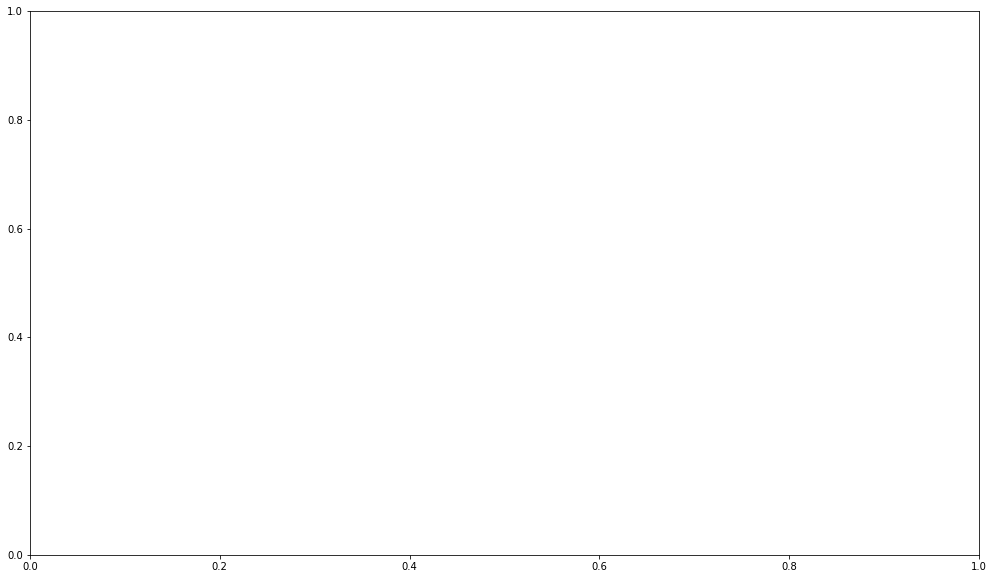

In [32]:
color_plots()
print('-----Generated cu_galex_sed_fitting_colorplots.pdf with color vs color plots.')

In [ ]:
general_color_plots()
print('----Generated cu_galex_color_byfilt.png and cu_galex_color_bygal.png showing color vs color for all gals.')

### Produce a PDF file showing template fits

In [ ]:
# this takes some time to run (about a minute per galaxy?)
with PdfPages('cu_galexsed_fitting.pdf') as pdf:
    print('\n ---------> Plotting templates and calculating chi values...\n')
    for gal in gal_names:#[0:5]
        fig = plt.figure(figsize=(17,10))
        ax = fig.add_subplot(1,1,1)
        print("---Fitting ", gal)
        chis = []
        for tem in templates:
            new_chi = template_comparison(gal, tem)
            chis.append(new_chi)
        bestchi_pos = chis.index(min(chis))
        result_string = "Galaxy - " + gal + " - lowest chi template: " + str(templates[bestchi_pos])
        print(result_string)
        plt.text(10, 10**-6.5, result_string, ha='center')
        pdf.savefig(bbox_inches="tight")
        plt.close('all')
    print('Finished!')